In [1]:
# first version of radial profile code
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio
import numpy as np
import sys as sys
mat_contents = sio.loadmat('onehund.mat') 
lfp = mat_contents["onehund"]
csdx = np.array([[0.003130],[0.003169],[0.004244],[0.003107],[0.004100],[0.005167],[0.002875],[0.003953],[0.004989],[0.006077],[0.003860],[0.004917],[0.005932],[0.004772],[0.005860],[0.005582]])
csdy = np.array([[0.002755],[0.003659],[0.002939],[0.004602],[0.003788],[0.002985],[0.005545],[0.004720],[0.003826],[0.003106],[0.005748],[0.004769],[0.003956],[0.005831],[0.004815],[0.005748]])
print(np.shape(csdx))
print("min x: ",np.min(csdx))
print("max x: ",np.max(csdx))
print("min y: ",np.min(csdy))
print("max y: ",np.max(csdy))
csd_x = np.flipud(csdx)
csd_y = np.flipud(csdy)
csd_at = np.hstack((csd_x,csd_y))
t_max = 0

(16, 1)
min x:  0.002875
max x:  0.006077
min y:  0.002755
max y:  0.005831


In [2]:
print(np.max(lfp))
print(np.min(lfp))
sigma = np.std(lfp)
mu = np.mean(lfp)

1877
-1041


In [3]:
evenind = 2*np.arange(lfp.shape[1]/2).astype(int)
oddind = (2*np.arange(lfp.shape[1]/2)+1).astype(int)
lfpeven = lfp[:,evenind]
lfpodd = lfp[:,oddind]
print(lfpeven.shape)
print(lfpodd.shape)

(16, 68)
(16, 68)


In [4]:
meanodd = np.mean(lfpodd, axis=1)
meaneven = np.mean(lfpeven, axis=1)
stdodd = np.std(lfpodd, axis=1)
stdeven = np.std(lfpeven, axis=1)
print(stdodd)

[274.80804051 258.96676852 295.73099092 276.35015838 301.29780522
 317.56830587 236.47244796 279.96919126 392.6600108  315.17493083
 263.00993804 433.98389932 307.39638414 225.50598432 292.20762455
 216.78136409]


In [5]:
print(oddind.shape[0])
print(meanodd.shape)
print(lfp[1,oddind].shape)

68
(16,)
(68,)


In [6]:
lfp2 = np.zeros((16,136))
for i in range(meanodd.shape[0]):
    lfp2[i,oddind] = (0.01*stdodd[i])*np.random.randn(oddind.shape[0])+meanodd[i]
for i in range(meaneven.shape[0]):
    lfp2[i,evenind] = (0.01*stdeven[i])*np.random.randn(evenind.shape[0])+meaneven[i]
print(lfp2.shape)

(16, 136)


In [7]:
#REDEFINE LFP VALUES BASED ON RANDOM UNIFORM DISTRIBUTION
#print(lfp.shape)
#First baseline test is for LFP values 
#that are randomly sampled from individual channel uniform distribution
#lfp2 = sigma*np.random.randn(16,136)+mu
#print(lfp2.shape)
#print(np.max(lfp2))
#print(np.min(lfp2))

In [8]:
lfp = lfp2

In [9]:
from scipy.interpolate import griddata
start = 0 #1280 #6030; #6030; #4981 #5980 #11500 #5990 #6010;
end = lfp.shape[1];
print(end)
dt = 0.003;
#n = end-start+1
n=lfp.shape[1]-1 #299 #100; #999;  #10;
lfp1=np.reshape(lfp[:,start],(-1,1))
grid_x, grid_y = np.mgrid[0.0031:0.0055:100j,                                                                                                                                                           
                  0.0031:0.0055:100j]

grid_z = griddata(csd_at, lfp1, (grid_x,grid_y),method='cubic') 
for x in range(n):  
    lfp1=np.reshape(lfp[:,start+1+x],(-1,1))  # start+1 because grid_z(:,:,0) already created  
    grid_z = np.dstack((grid_z,griddata(csd_at, lfp1, (grid_x,grid_y),method='cubic'))) #"cubic")))
    t_max_tmp = np.nanmax(np.abs(grid_z[:,:,x]))
    if t_max_tmp > t_max:
        t_max=t_max_tmp
print(t_max)
print(np.shape(grid_x))
print(np.shape(grid_y))
print(np.shape(grid_z))

136
442.8822489148379
(100, 100)
(100, 100)
(100, 100, 136)


In [10]:
cx = (int) (grid_z.shape[0]/2)
cy = (int) (grid_z.shape[1]/2)

In [11]:
import math
import copy
import scipy.signal as scp
lfpmaxangle = []
lfpminangle = []
lfpmaxval = []
lfpminval = []
lfpradprof = []
for num in range(n):
    #Normalization
    img = copy.deepcopy(grid_z[:,:,num])
    #img = img-minval
    #img = img/(maxval-minval)
    #img = img-np.min(img)
    #img = img/(np.max(img)-np.min(img))
    for x in range(grid_z.shape[0]):
        for y in range(grid_z.shape[1]):
            if((x-cx)*(x-cx)+(y-cy)*(y-cy)>2500):
                img[x,y] = 0;
    f = np.fft.fft2(img)
    
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    img = np.rot90(img)
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_b = np.rot90(img_back)
    radii = []
    sumradii1 = []
    sumradii2 = []
    for r in range(360):
        width = magnitude_spectrum.shape[0]
        height = magnitude_spectrum.shape[1]
        theta = 2 * math.pi * r / 360;
        dx = (math.cos(theta));
        dy = (math.sin(theta));
        w2 = width * width / 4;
        h2 = height * height / 4;
        m = math.sqrt(w2 * h2 / (dx * dx * h2 + dy * dy * w2));
        x = (cx + m * dx);
        y = (cy + m * dy);
        distance = math.sqrt((x-cx)*(x-cx)+(y-cy)*(y-cy))
        nr = 20;
        radialsum1 = 0;
        radialsum2 = 0;
        for s in range(1,nr):
            sx = (int)(cx + s*distance/nr*dx)
            sy = (int)(cy + s*distance/nr*dy)
            radialsum1 = radialsum1 + grid_z[sx,sy,num];
            radialsum2 = radialsum2 + magnitude_spectrum[sx,sy];
        radii.append(r);
        sumradii1.append(radialsum1);
        sumradii2.append(radialsum2);
    print('Image '+str(num))
    print('Max located at: '+str(radii[np.argmax(sumradii1)])+" degrees, Val: "+str(np.max(sumradii1)))
    print('Min located at: '+str(radii[np.argmin(sumradii1)])+" degrees, Val: "+str(np.min(sumradii1)))
    filtsumrad2 = scp.savgol_filter(sumradii2, 53, 3) #FFT Magnitude Spectrum Filtered
    lfpmaxangle.append(radii[np.argmax(sumradii1)])
    lfpminangle.append(radii[np.argmin(sumradii1)])
    lfpmaxval.append(np.max(sumradii1))
    lfpminval.append(np.min(sumradii1))
    lfpradprof.append(sumradii1)

Image 0
Max located at: 257 degrees, Val: 852.0826746668565
Min located at: 54 degrees, Val: 128.8105692846989
Image 1
Max located at: 264 degrees, Val: 7863.139398211094
Min located at: 132 degrees, Val: 6372.720515402862
Image 2
Max located at: 255 degrees, Val: 902.858472627217
Min located at: 54 degrees, Val: 121.69986182381389
Image 3
Max located at: 260 degrees, Val: 7868.014503172174
Min located at: 132 degrees, Val: 6285.655737227805
Image 4
Max located at: 257 degrees, Val: 817.9717974882855
Min located at: 54 degrees, Val: 38.129442496058644
Image 5
Max located at: 260 degrees, Val: 7888.676808498459
Min located at: 132 degrees, Val: 6399.594583215293
Image 6
Max located at: 255 degrees, Val: 900.4986890726043
Min located at: 42 degrees, Val: 97.23759917197263
Image 7
Max located at: 260 degrees, Val: 7837.7224449831465
Min located at: 132 degrees, Val: 6255.364289266596
Image 8
Max located at: 257 degrees, Val: 768.5287323463826
Min located at: 42 degrees, Val: 83.7510034146

Image 81
Max located at: 260 degrees, Val: 7795.355847773987
Min located at: 132 degrees, Val: 6300.751234550946
Image 82
Max located at: 257 degrees, Val: 886.9107466921171
Min located at: 54 degrees, Val: 98.62226728530794
Image 83
Max located at: 260 degrees, Val: 7772.347606936206
Min located at: 132 degrees, Val: 6465.580226637368
Image 84
Max located at: 257 degrees, Val: 904.75199094481
Min located at: 42 degrees, Val: 122.5630520367962
Image 85
Max located at: 260 degrees, Val: 7775.431823090403
Min located at: 132 degrees, Val: 6426.270501923888
Image 86
Max located at: 257 degrees, Val: 925.2646712720809
Min located at: 54 degrees, Val: 89.31861401050703
Image 87
Max located at: 265 degrees, Val: 7798.195463137841
Min located at: 132 degrees, Val: 6281.612897302103
Image 88
Max located at: 255 degrees, Val: 896.7482082997221
Min located at: 36 degrees, Val: 109.55520780704282
Image 89
Max located at: 264 degrees, Val: 7677.38973880199
Min located at: 132 degrees, Val: 6300.99

In [12]:
# Convert lists to array
lfpmaxangle = np.asarray(lfpmaxangle)
lfpminangle = np.asarray(lfpminangle)
lfpmaxval = np.asarray(lfpmaxval)
lfpminval = np.asarray(lfpminval)
lfpradprof = np.asarray(lfpradprof)

In [13]:
# Correlation of Correlations 
#(i.e. correlation coef for if pre correlation high then is post correlation high)
corrind = []
corrind2 = []
for num in np.arange(n):
    for num2 in np.arange(num+1,n):
        if(num%2==0 and num2%2==0 and num<134 and num2<134):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
        elif(num%2==1 and num2%2==1):
            corrind2.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
print(len(corrind))
print(len(corrind2))
print(np.corrcoef(corrind, corrind2))

2211
2211
[[1.         0.02214235]
 [0.02214235 1.        ]]


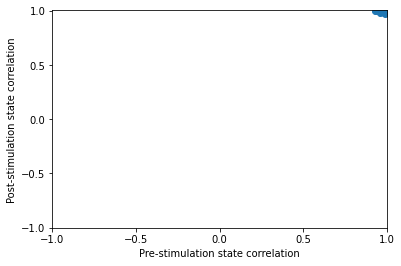

In [14]:
plt.scatter(corrind, corrind2)
plt.rcParams.update({'font.size': 14})
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.xlabel('Pre-stimulation state correlation')
plt.ylabel('Post-stimulation state correlation')
plt.show()

In [15]:
from scipy.stats import linregress
linregress(corrind, corrind2)

LinregressResult(slope=0.011783821889915676, intercept=0.9850608078194865, rvalue=0.02214235229011295, pvalue=0.2980146321453933, stderr=0.01132030337072088)

In [16]:
# Correlation of Pre and Post States
corrind3 = []
for num in np.arange(n):
    for num2 in np.arange(n):
        if(num%2==0 and num2%2==0):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])

In [17]:
# Correlation Heatmap
corrind = []
corrind2 = []
for num in np.arange(n):
    for num2 in np.arange(n):
        if(num%2==0 and num2%2==0):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
        elif(num%2==1 and num2%2==1):
            corrind2.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])

In [18]:
print(n)

135


In [19]:
corrmat = np.asarray(corrind).reshape((int(n/2)+1,int(n/2)+1))
corrmat2 = np.asarray(corrind2).reshape((int(n/2),int(n/2)))

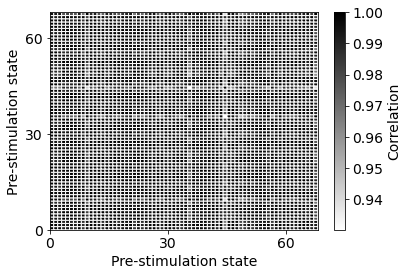

In [20]:
fig, ax = plt.subplots()
im = ax.pcolormesh(corrmat, cmap=cm.binary, edgecolors='white', linewidths=1, antialiased=True)
plt.rcParams.update({'font.size': 14})
plt.xlabel('Pre-stimulation state')
plt.ylabel('Pre-stimulation state')
plt.xticks([0,30,60])
plt.yticks([0,30,60])
#plt.title('Heatmap of Pre-stimulation Radial Profile Correlation')
fig.colorbar(im, label='Correlation')
plt.show()

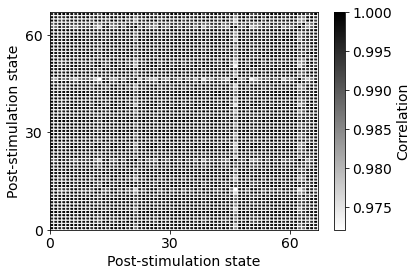

In [21]:
fig, ax = plt.subplots()
im = ax.pcolormesh(corrmat2, cmap=cm.binary, edgecolors='white', linewidths=1, antialiased=True)
fig.colorbar(im, label='Correlation')
#plt.title('Heatmap of Post-stimulation Radial Profile Correlation')
plt.xlabel('Post-stimulation state')
plt.ylabel('Post-stimulation state')
plt.xticks([0,30,60])
plt.yticks([0,30,60])
plt.show()

In [22]:
numpostcorr = 0
contdepmeans = []
contextdependent = []
for num in np.arange(n):
    corr = []
    precorr = []
    print('Image '+str(num))
    for num2 in np.arange(num+1, n):
        if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
            print(str(num2)+': '+str(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]))
            corr.append(num2)
            if(num<134 and num2<134):
                precorr.append(np.corrcoef(lfpradprof[num+1], lfpradprof[num2+1])[0, 1])
    if(num%2==0):
        if(len(corr)==0):
            contextdependent.append(-1)
        else:
            numpostcorr = numpostcorr+1
            nprecorr = len(np.argwhere(np.asarray(precorr)>0))
            contdepmeans.append(np.mean(precorr))
            contextdependent.append(nprecorr/len(corr))

Image 0
2: 0.9986356372119627
4: 0.9985100384780894
6: 0.9916705798998021
8: 0.9946030114441299
10: 0.992276975900515
12: 0.990616200337602
14: 0.9988278482310802
16: 0.9860676394678054
18: 0.9972416640412298
20: 0.9973707089011876
22: 0.9982392697370882
24: 0.9921234843516662
26: 0.9890031796220113
28: 0.9979383496716816
30: 0.9975594957031287
32: 0.993539371258429
34: 0.9902743344769533
36: 0.9960145301477413
38: 0.9978990424698634
40: 0.9992241537437886
42: 0.9849436786190048
44: 0.994593362613129
46: 0.9875494272014139
48: 0.9937217645113183
50: 0.9995297860859215
52: 0.9994204336809839
54: 0.9905393228766967
56: 0.990218765715015
58: 0.9983318803734418
60: 0.9996635028488021
62: 0.9960636884092127
64: 0.9916978945971148
66: 0.9883435984873726
68: 0.9973412759279974
70: 0.9938295166852337
72: 0.9973876864142843
74: 0.9995360795357963
76: 0.9985786567550704
78: 0.9981313357955703
80: 0.9916309462933013
82: 0.9971087678871314
84: 0.9908887626846294
86: 0.9993321711119649
88: 0.964574

12: 0.9996243249133412
14: 0.9955639135841693
16: 0.9988322285936683
18: 0.981104819976424
20: 0.9977232450298699
22: 0.9952776153962166
24: 0.9996582771933872
26: 0.9996426274126039
28: 0.9941232438692525
30: 0.9968597415225591
32: 0.9997876743929754
34: 0.9993864415738011
36: 0.998845695652582
38: 0.9966889544215708
40: 0.9949758196812064
42: 0.9987816360118873
44: 0.9995487451384953
46: 0.9991954377919647
48: 0.998594459727332
50: 0.9945273248058544
52: 0.9944421400218193
54: 0.9995606280943058
56: 0.9995865811672503
58: 0.9935503039942962
60: 0.9932446128620871
62: 0.9983346982394908
64: 0.9995979835998778
66: 0.9996568100346764
68: 0.9980065139643689
70: 0.9718150043619849
72: 0.99700630225193
74: 0.9905158930315088
76: 0.9967523399035915
78: 0.9965705971958351
80: 0.9996144222476866
82: 0.998297730351227
84: 0.9999034778035022
86: 0.9873415742209946
88: 0.9898787456400626
90: 0.9893262844024193
92: 0.9906922220681904
94: 0.9978046678919046
96: 0.9974326039158723
98: 0.99890308193

35: 0.9958245645072725
37: 0.9987629775535294
39: 0.995981936907012
41: 0.9961526240508903
43: 0.9866333430359113
45: 0.9991304402016944
47: 0.9968395856631536
49: 0.9993534905231884
51: 0.9994416759390297
53: 0.9977682482686999
55: 0.9956600438374875
57: 0.997846903808733
59: 0.9990893192840246
61: 0.9952231512150191
63: 0.9981687444689877
65: 0.9994150506380649
67: 0.9956614843418108
69: 0.999184905866368
71: 0.9970965363385726
73: 0.9993422766977709
75: 0.9966944114220075
77: 0.9991076511085646
79: 0.9976675547411825
81: 0.9994933218536952
83: 0.9974854636394713
85: 0.9981748181821695
87: 0.9976635195413672
89: 0.999652029843564
91: 0.9925091716093853
93: 0.9793106805391378
95: 0.9993808108101683
97: 0.9981963240257694
99: 0.9952615778022911
101: 0.9988119533002503
103: 0.998523202973136
105: 0.9972870429069636
107: 0.9964738117529792
109: 0.9975635979543531
111: 0.9961319639092346
113: 0.9992094958703047
115: 0.9958436642695252
117: 0.9995642994236146
119: 0.9989084922223919
121: 0

119: 0.9983580879536482
121: 0.9983752319167126
123: 0.9991807957197053
125: 0.9926058877911434
127: 0.9908235740068011
129: 0.9980542400341883
131: 0.9989010045005524
133: 0.9976865179900056
Image 20
22: 0.99849537884873
24: 0.9974902416460676
26: 0.9965248308858576
28: 0.9989240812515867
30: 0.9995254833342058
32: 0.9985675327951404
34: 0.997346555603813
36: 0.9995458704251424
38: 0.9995136726569523
40: 0.9985165868462921
42: 0.994261694085979
44: 0.9987642608848704
46: 0.9954191302752706
48: 0.9977321447719604
50: 0.9986276147892765
52: 0.9988047076951304
54: 0.9977030200068066
56: 0.9970704528748442
58: 0.9986557834814892
60: 0.998012683499754
62: 0.9998346093793431
64: 0.9970192792663561
66: 0.9961368904457002
68: 0.9990441956423929
70: 0.9847909841128448
72: 0.9997313580547778
74: 0.9972361222378522
76: 0.999596939758721
78: 0.9994503820443615
80: 0.9971995854637632
82: 0.999910384405152
84: 0.9973157886667163
86: 0.9948993723048665
88: 0.9785600576623676
90: 0.9967566305860143
9

111: 0.9994155980156229
113: 0.99808452996521
115: 0.9995752301556134
117: 0.9948313380530059
119: 0.9975661010311745
121: 0.9970845160039417
123: 0.9993543334992449
125: 0.9961439141736521
127: 0.9938516156514821
129: 0.9948486447835835
131: 0.996769057143036
133: 0.9992787917185512
Image 28
30: 0.9981020742396225
32: 0.9952758910184597
34: 0.9946272369296121
36: 0.9972488819274745
38: 0.9985083985410976
40: 0.9973485452903885
42: 0.9892111222285963
44: 0.9955910844734545
46: 0.9903061504981732
48: 0.9937303888653808
50: 0.9979800013135077
52: 0.9982984237921526
54: 0.994493103580199
56: 0.9928727019471839
58: 0.9999180826631773
60: 0.9975995180819295
62: 0.998571531128327
64: 0.9927981614194892
66: 0.9917279611616885
68: 0.9971140282675695
70: 0.9893229243930406
72: 0.9994627595414188
74: 0.9987315788088512
76: 0.9985307248440741
78: 0.9979671477663259
80: 0.9930632381934447
82: 0.9983227598602306
84: 0.9935092319122979
86: 0.9959866078568953
88: 0.969162968877466
90: 0.9984695692006

68: 0.9990652903372091
70: 0.9810331155171319
72: 0.9987899190536849
74: 0.9952949927452791
76: 0.9990764190768432
78: 0.9993160656528167
80: 0.9988686502977361
82: 0.9998138634218949
84: 0.9986932590689587
86: 0.9930905051574065
88: 0.9832896407660515
90: 0.9946713981673079
92: 0.9957210515529792
94: 0.9992875082099879
96: 0.9936207520335093
98: 0.9964413716251115
100: 0.9987212996748557
102: 0.9948443793308273
104: 0.9992680583171253
106: 0.9991898263954289
108: 0.9980414346629344
110: 0.9932389920120072
112: 0.9964738764832943
114: 0.9994740525358101
116: 0.9959543915722114
118: 0.999736126497571
120: 0.9996410523331034
122: 0.9989274760868866
124: 0.9981367586981184
126: 0.9984961585746838
128: 0.9987915458994794
130: 0.9947776997310626
132: 0.9987403648450969
134: 0.9851530260345449
Image 37
39: 0.9962901006225156
41: 0.9974523826026598
43: 0.988717884645616
45: 0.9973177084279391
47: 0.9975820418341795
49: 0.9998081925233356
51: 0.999134658561506
53: 0.9992338879869068
55: 0.9963

95: 0.9991238660517144
97: 0.9969443228810535
99: 0.9959962047950218
101: 0.9980248931583486
103: 0.997018660055219
105: 0.9956171800892701
107: 0.9982577597371959
109: 0.9959803432874431
111: 0.9971594996283185
113: 0.9989214929985207
115: 0.995767792239582
117: 0.9993859020244972
119: 0.9983704418737022
121: 0.9989945169170674
123: 0.9975926380034421
125: 0.9859021768696308
127: 0.9961531947097394
129: 0.9954988175316809
131: 0.995311918670484
133: 0.9966032700100101
Image 46
48: 0.9983866995516676
50: 0.9914563895724363
52: 0.9915762227408886
54: 0.9990642787758985
56: 0.9997722814882734
58: 0.9894107922907971
60: 0.9899052487787969
62: 0.9962224960315109
64: 0.9988743355800952
66: 0.9997605721341973
68: 0.9954221463931415
70: 0.9650579130809227
72: 0.9939520038462987
74: 0.9859689930933275
76: 0.9940086082420693
78: 0.9946607514661874
80: 0.9992819648262372
82: 0.9962927359579865
84: 0.999360446500456
86: 0.9828839423770619
88: 0.9935384585697963
90: 0.9849720285555051
92: 0.986992

84: 0.9996534817688634
86: 0.9858684720588587
88: 0.9911409244464143
90: 0.9880754688385853
92: 0.9898334015969568
94: 0.9981184213342146
96: 0.9979959830334024
98: 0.9994119729686695
100: 0.9986153723837358
102: 0.9971218239300351
104: 0.9989151221809601
106: 0.997183825153548
108: 0.9942604106643191
110: 0.9862330618955448
112: 0.9992426816364143
114: 0.9978803896114298
116: 0.9899147723926512
118: 0.9993135310581032
120: 0.9981426921274094
122: 0.9998026329754951
124: 0.9976320353371377
126: 0.9947195769810725
128: 0.9950780705130482
130: 0.9888135236617186
132: 0.9987235941570142
134: 0.9751676584433235
Image 57
59: 0.9987876848632475
61: 0.9980544257467789
63: 0.9990073248019323
65: 0.9988637914317452
67: 0.997950515883786
69: 0.9972964056131497
71: 0.9990542451332574
73: 0.9979860917236992
75: 0.9970976292955182
77: 0.9972157840996159
79: 0.9973958779396984
81: 0.9979894216859012
83: 0.9975950007283348
85: 0.997249854523987
87: 0.9970411745293922
89: 0.9974781248046803
91: 0.9950

114: 0.9988185017193514
116: 0.996261396157591
118: 0.9985934775554447
120: 0.9985885153404689
122: 0.9970826372165638
124: 0.9974051393093321
126: 0.9982589011721581
128: 0.9991490811030406
130: 0.9955081019366744
132: 0.99729131338017
134: 0.9873164612704968
Image 69
71: 0.9978373921195779
73: 0.9986263145954619
75: 0.9987129209505978
77: 0.997516127400846
79: 0.998315851337516
81: 0.9995640203370093
83: 0.9990723676167405
85: 0.9990385760843511
87: 0.997785957889305
89: 0.9986854830549302
91: 0.995717045333654
93: 0.9854690581209012
95: 0.9991258655960968
97: 0.9985226957515175
99: 0.997514634654871
101: 0.9965614003333382
103: 0.9976010967749531
105: 0.9974727434855737
107: 0.9976069113125923
109: 0.9986232346943571
111: 0.9976394028471464
113: 0.9994428753829605
115: 0.9981250787948032
117: 0.9984682191277805
119: 0.9989649329648449
121: 0.9990137257120126
123: 0.9990451106041354
125: 0.9900998647142335
127: 0.9950293036786172
129: 0.9967515132299204
131: 0.9979927166504265
133: 0

86: 0.9863737661492163
88: 0.9907187438114828
90: 0.9884813186955367
92: 0.9898936341087181
94: 0.997556762397444
96: 0.9978207927499124
98: 0.9991900504666417
100: 0.9986912306640727
102: 0.9966643255029024
104: 0.9995659133125557
106: 0.9973330430633076
108: 0.9945004557200324
110: 0.9872697613192244
112: 0.9993573474138793
114: 0.9983196839388937
116: 0.9903164797525011
118: 0.999406789816504
120: 0.9982667464611308
122: 0.9992427904705415
124: 0.997111693341111
126: 0.9953153457670663
128: 0.99535775912787
130: 0.9886348818689721
132: 0.9980378138942266
134: 0.9756154771268596
Image 85
87: 0.9952233705432205
89: 0.9976784425975052
91: 0.9952137834807977
93: 0.9869110001368486
95: 0.9980465116598066
97: 0.9966245231829319
99: 0.9973244429491388
101: 0.9949866841742144
103: 0.9950132890697362
105: 0.9951700464039762
107: 0.9982426833280268
109: 0.9965131895817269
111: 0.9977695502259952
113: 0.9990762662782938
115: 0.9969941247563229
117: 0.9985512281532043
119: 0.9992810810325227
12

118: 0.9996692249059806
120: 0.999275224700986
122: 0.9985701685523826
124: 0.996433271152624
126: 0.9974265357615486
128: 0.9968323811450279
130: 0.9907772284991696
132: 0.9973356454848457
134: 0.97992457299987
Image 105
107: 0.9944842652684108
109: 0.9994357955053881
111: 0.9963417163396304
113: 0.9980748817679609
115: 0.9977645368312837
117: 0.9956921638967474
119: 0.9974269261964864
121: 0.9980798149685022
123: 0.9982320214778764
125: 0.9889923240877937
127: 0.9879449732785612
129: 0.9992616552827859
131: 0.999399199028326
133: 0.9957599493268701
Image 106
108: 0.9993399000931117
110: 0.9953459706702673
112: 0.9950722444425641
114: 0.999723624383608
116: 0.9964641296545764
118: 0.9991131615572479
120: 0.9998495459440031
122: 0.9972903204823956
124: 0.9951514864450818
126: 0.9993757117650639
128: 0.9982023307960466
130: 0.9940789409300841
132: 0.9963841428167551
134: 0.985915484786115
Image 107
109: 0.9950661369090249
111: 0.9994509338201107
113: 0.9983333416803278
115: 0.9976122597

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [23]:
numpostcorr = 0
contdepmeans = []
contextdependent = []
for num in np.arange(n):
    corr = []
    precorr = []
    for num2 in np.arange(num+1, n):
        if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
            corr.append(num2)
            if(num>0 and num2>0 and num%2==1):
                precorr.append(np.corrcoef(lfpradprof[num+1], lfpradprof[num2+1])[0, 1])
    if(num%2!=0):
        if(len(corr)==0):
            contextdependent.append(-1)
        else:
            numpostcorr = numpostcorr+1
            nprecorr = len(np.argwhere(np.asarray(precorr)>0))
            contdepmeans.append(np.mean(precorr))
            contextdependent.append(nprecorr/len(corr))

In [24]:
numpostcorr

66

In [25]:
num/2

67.0

In [26]:
contextdependent

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 -1]

In [28]:
len(np.argwhere(np.asarray(contextdependent)>0.7))

66

In [42]:
#Repeat but shuffle prestates
shuffledarr = 2*np.arange(n/2).astype(int)
#Permutation
ncdpermutation = []
ncdpermmean = []
for perm in range(1000):
    np.random.shuffle(shuffledarr)
    numpostcorr = 0
    contdepmeans = []
    contextdependent = []
    for num in np.arange(n):
        corr = []
        precorr = []
        for num2 in np.arange(num+1, n):
            if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
                corr.append(num2)
                if(num>0 and num2>0 and num%2==1):
                    precorr.append(np.corrcoef(lfpradprof[shuffledarr[(int)((num-1)/2)]], lfpradprof[shuffledarr[(int)((num2-1)/2)]])[0, 1])
        if(num%2!=0):
            if(len(corr)==0):
                contextdependent.append(-1)
            else:
                numpostcorr = numpostcorr+1
                nprecorr = len(np.argwhere(np.asarray(precorr)>0))
                contdepmeans.append(np.mean(precorr))
                contextdependent.append(nprecorr/len(corr))
    print(perm)
    ncdpermutation.append(len(np.argwhere(np.asarray(contextdependent)>0.7)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [43]:
print(np.mean(ncdpermutation))

66.0


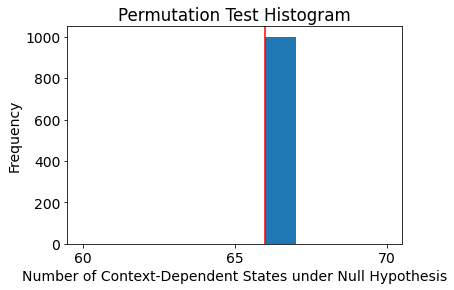

In [53]:
plt.hist(np.asarray(ncdpermutation), bins=10, range=(60,70))
plt.axvline(x=66).set_color('red')
plt.xticks([60,65,70])
plt.title('Permutation Test Histogram')
plt.ylabel('Frequency')
plt.xlabel('Number of Context-Dependent States under Null Hypothesis')
plt.show()

In [54]:
len(np.argwhere(np.asarray(ncdpermutation)>66))

0

In [47]:
np.std(ncdpermutation)

0.0